## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

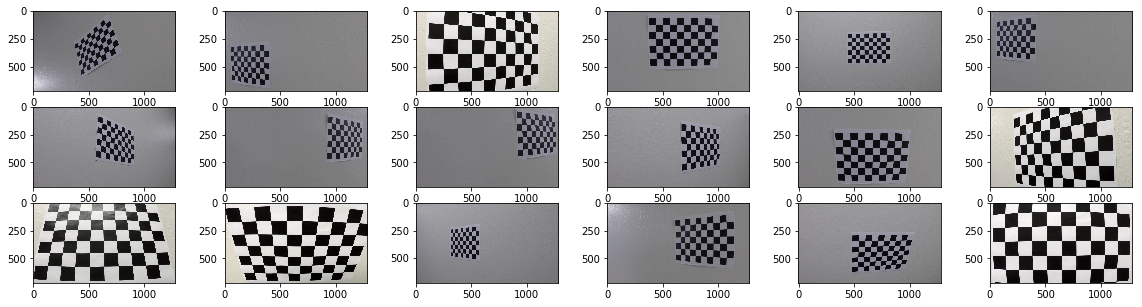

In [4]:
# show images
def show_images(images_list, cols=1):
    '''
    para: images_list, list of arrays
    '''
    fig = plt.figure(figsize=(20, 5))
    length = len(images_list)
    rows = length // cols
    for index in range(1, length-1):
        fig.add_subplot(rows, cols, index)
        plt.imshow(images_list[index])
    plt.show()

# test show_images
images_list = [plt.imread(image) for image in images]
show_images(images_list, 6)

In [5]:
# Step through the list and search for chessboard corners
des_images = []
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        des_images.append(cv2.drawChessboardCorners(img, (9,6), corners, ret))

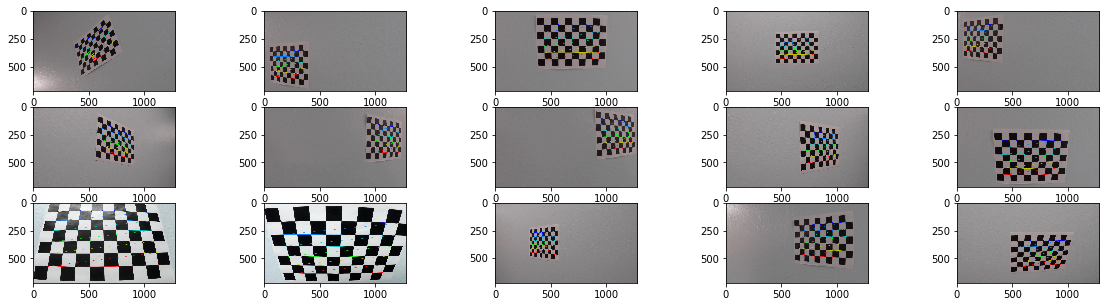

In [6]:
show_images(des_images, 5)

In [7]:
image_size = des_images[0].shape

In [8]:
image_size

(721, 1281, 3)

In [9]:
# calibrate camera
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720, 1280), None, None)

In [10]:
# distort images
des = cv2.undistort(des_images[0], cameraMatrix, distCoeffs)

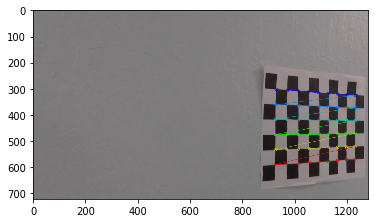

In [11]:
plt.imshow(des)

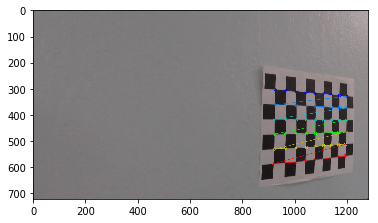

In [12]:
plt.imshow(des_images[0])

In [13]:
undistort_images = [cv2.undistort(image, cameraMatrix, distCoeffs) for image in images_list]

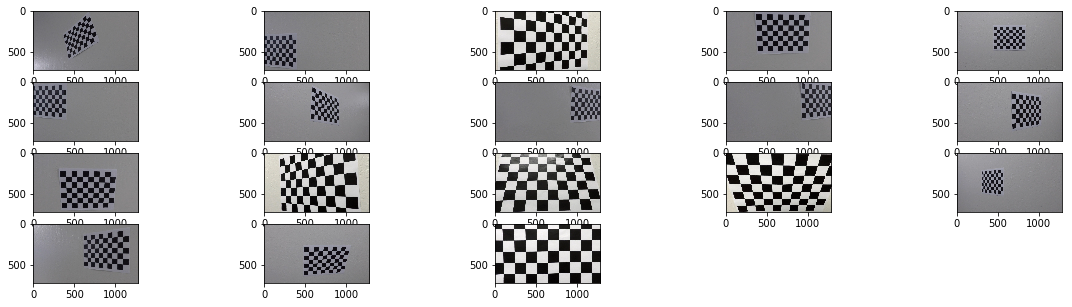

In [14]:
show_images(undistort_images, 5)

In [15]:
objpoints[0].shape

(54, 3)

## log
1. 尝试使用单个图片的3D真实坐标和cv找到的棋盘上的点来标定相机, 报错, 需要使用多个点以及多个相机corners.
    - 解答: 标定相机需要至少2个标定数据, 一个是不够的.
2. BUG: objectPoints should contain vector of vectors of points of type Point3f
    - 解决: 类型错误, 应该是float32的类型, np.zeros的默认类型是float64.

In [18]:
nx, ny = 9, 6 # nx, ny for pattern.
objpoints = np.zeros((nx * ny, 3), np.float32) # for one image.
objpoints[:, :2] = np.mgrid[:nx,:ny].T.reshape(-1, 2)
objpoints_list = [] # for list of images
imagepoints_list = []
image_shape = images_list[0].shape[:-1]
height, width = image_shape
patternsize = (nx, ny)
# undistort and transform perspective
for image in images_list:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    
    ret, corners = cv2.findChessboardCorners(image, patternsize)
    if ret:
        imagepoints_list.append(corners)
        objpoints_list.append(objpoints)
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints_list, imagepoints_list, image_shape, None, None)
undistort_images_list = [cv2.undistort(image, cameraMatrix, distCoeffs) for image in images_list]

### NOTE
- getPerspectiveTransform的参数
    - src: 真实世界中的四个顶点坐标.
        - 这个就是棋盘的四个顶点坐标.
    - dst: 输出图片的四个对应坐标.
        - 这个是图片的四个顶点, 和图片的尺寸有关.

In [28]:
objpoints[nx-1]

array([ 8.,  0.,  0.], dtype=float32)

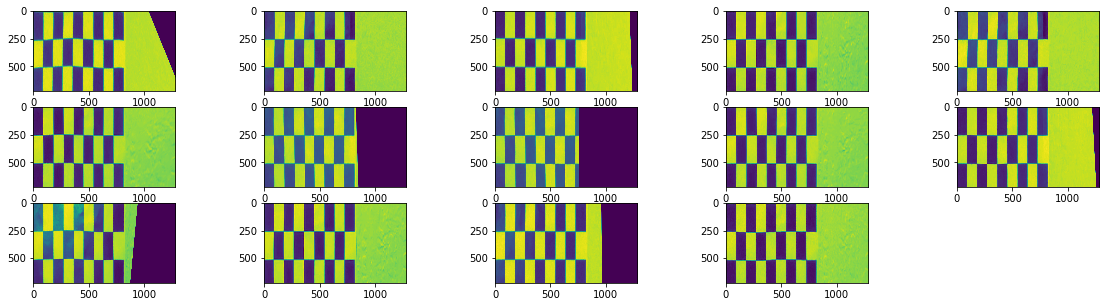

In [38]:
warp_list = []
for undistort_image in undistort_images_list:
    undistort_image = cv2.cvtColor(undistort_image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(undistort_image, patternsize)
    if ret:
        src = np.float32([corners[0], corners[nx-1], corners[-nx], corners[-1]])
        dst = np.float32([(0,0), (height, 0), (0, width), (height, width)])
        M = cv2.getPerspectiveTransform(src, dst)
        warp_list.append(cv2.warpPerspective(undistort_image, M, (width, height)))

show_images(warp_list, 5)